# 概要

浅田 稔らによって発表されたDeep Modality Blending Networks(DMBN)は、複数の感覚器からの入力を1つに統合して学習することで、模倣行動のような能力を獲得することが示された。
* [Imitation and mirror systems in robots through Deep Modality Blending Networks](https://www.sciencedirect.com/science/article/pii/S0893608021004329?via%3Dihub)
* [Deep-Modality-Blending-Networks](https://github.com/myunusseker/Deep-Modality-Blending-Networks)

このモデルは非常に興味深く、AIが行動の概念を学習できる可能性がある

ここでは、モデルの実装をオブジェクト指向で再利用しやすいpytorchで行い、簡単に利用できるように\[pytorch_dmbn\]のpipライブラリとしてまとめる


# 1.ライブラリの準備

ローカルの実装修正をすぐに反映するため、pytorch_dmbnのライブラリとして再インストールする

* --upgradeと--force-reinstallは再インストールを保証
* --no-depsは依存関係の再インストールを回避します。<br>
そうでなければ、pipがNumpyや他の大きなパッケージを再コンパイルし始めるという問題に遭遇するかもしれません。
* -e コマンドは開発モードでパッケージをインストールするので、ソースコードを変更するとすぐ反映されて便利です。
* . 現在のフォルダからインストールする

参考
* [[1]](https://www.web-dev-qa-db-ja.com/ja/python/%E7%8F%BE%E5%9C%A8%E3%81%AE%E3%83%90%E3%83%BC%E3%82%B8%E3%83%A7%E3%83%B3%E3%82%92%E5%BC%B7%E5%88%B6%E7%9A%84%E3%81%AB%E5%86%8D%E3%82%A4%E3%83%B3%E3%82%B9%E3%83%88%E3%83%BC%E3%83%AB%E3%81%99%E3%82%8B%E3%81%93%E3%81%A8%E3%81%AF%E3%81%A7%E3%81%8D%E3%81%BE%E3%81%99%E3%81%8B%EF%BC%9F/1043267345/) 現在のバージョンを強制的に再インストールすることはできますか？
* [[2]](https://qiita.com/propella/items/803923b2ff02482242cd) Python でパッケージを開発して配布する標準的な方法


In [1]:
!pip install --upgrade --no-deps --force-reinstall -e .

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///workspace
  Preparing metadata (setup.py) ... done
  Attempting uninstall: pytorch-dmbn
    Found existing installation: pytorch-dmbn 0.0.1
    Uninstalling pytorch-dmbn-0.0.1:
      Successfully uninstalled pytorch-dmbn-0.0.1
  DEPRECATION: Legacy editable install of pytorch-dmbn==0.0.1 from file:///workspace (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457
  Running setup.py develop for pytorch-dmbn


In [2]:
# TestPyPIからインストールする
# !pip install pytorch_dmbn --index-url https://test.pypi.org/simple/ pytorch_dmbn
# import pytorch_dmbn

モデルの利用に必要なインポートを記述

In [3]:
from pytorch_dmbn.nn import BlendingEncoder
from pytorch_dmbn.nn import TimeDistributed
from pytorch_dmbn.nn import TimeAverageEncoder
from pytorch_dmbn.nn import ImageEncoder
from pytorch_dmbn.nn import ImageDecoder
from pytorch_dmbn.nn import LinearEncoder
from pytorch_dmbn.nn import CNPsLoss

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# GPUデバイス読み込み
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cuda:0
2.1.0a0+fe05266


* [tensorflowのEmbedding レイヤーは何をするか？](https://qiita.com/9ryuuuuu/items/e4ee171079ffa4b87424)
    * GlobalAveragePooling1D() レイヤーは、Embedding レイヤーで得られた値を平均値で圧縮する。
    * 出力は比べてコンパクトになるが、情報圧縮により単語の前後関係が失われることは気に留めるべきである。
* [PyTorchでGlobal Max PoolingとGlobal Average Poolingを使う方法](https://www.xn--ebkc7kqd.com/entry/pytorch-pooling)

## メモリ使用状況の確認

* [【Python基礎】psutilによるメモリの使用状況の取得とJupyter Notebookにメモリ使用状況を表示する方法](https://3pysci.com/memorysize-1/)
* [jupyter notebook上でPCのGPUチェック](https://qiita.com/Ringa_hyj/items/956e89e46aec3fb855b0)
* [nvidia-smiコマンドの詳細ついて](https://qiita.com/miyamotok0105/items/1b34e548f96ef7d40370)

In [5]:
# GPU情報
!nvidia-smi

Wed Sep  4 15:18:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 12GB          On  | 00000000:01:00.0 Off |                  Off |
| 30%   37C    P5              20W /  70W |     12MiB / 12282MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 2.モデルの準備

In [6]:
# デフォルトのdtypeを設定する
torch.set_default_dtype(torch.float)
print(torch.get_default_dtype())

torch.float32


### DMBNを構築

In [7]:
# エンコーダを並べる
encoders = [
    ImageEncoder(image_size = (128,128), channels = [4,32,64,64,128,128,256], linear_features = 128), # 画像データのエンコーダ
    LinearEncoder(channels = [8,32,64,64,128,128,256,128]) # 関節データのエンコーダ
]
encoders = [TimeAverageEncoder(encoder) for encoder in encoders]

# エンコーダの出力を、1つの層にまとめるBlendingEncoderへ入力する
blending_encoder = BlendingEncoder(encoders, in_features=129, linear_features=1024,)
blending_encoder.to(device) # GPUにロード

# デコーダーの出力は、入力に対する平均と分散の推測値
# 従って、デコーダーの出力チャンネル数は、入力チャンネル数の倍になる(平均と分散をそれぞれ出力するため)
decoders = nn.ModuleList([
    ImageDecoder(in_features=1024, channels=[256,128,128,64,64,32,16,8,6], conv_kernel_size=3, upsample_scale=2, image_size=(128,128)), # 画像データのデコーダ
    LinearEncoder(channels = [1024,512,216,128,32,14]) # 関節データのデコーダ
])
decoders.to(device) # GPUにロード

ModuleList(
  (0): ImageDecoder(
    (decoder_layers): ModuleList(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Upsample(scale_factor=2.0, mode='nearest')
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
      (5): Upsample(scale_factor=2.0, mode='nearest')
      (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (7): ReLU()
      (8): Upsample(scale_factor=2.0, mode='nearest')
      (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (10): ReLU()
      (11): Upsample(scale_factor=2.0, mode='nearest')
      (12): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (13): ReLU()
      (14): Upsample(scale_factor=2.0, mode='nearest')
      (15): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (16): ReLU()
      (17): Upsample(scale_factor=2.0, mode='nearest')
      (18): Conv2d(16, 8, kernel_size=

In [8]:
# モデルがGPUにあることを確認
# https://discuss.pytorch.org/t/how-to-check-if-model-is-on-cuda/180
print(next(blending_encoder.parameters()).is_cuda)
print(next(decoders.parameters()).is_cuda)

True
True


# 3. トレーニング

In [9]:
# 損失関数
cnps_loss = CNPsLoss()

# Adamオプティマイザの定義
optimizer = optim.Adam(
    list(blending_encoder.parameters()) + list(decoders.parameters()),
    lr=0.001
)

In [10]:
# 保存済みのモデルがあれば読み込み
from pytorch_dmbn.utils.save import NumberingSaver
saver = NumberingSaver()
save_name = "dmbn_test"
state = {
    'encoder': blending_encoder.state_dict(),
    'decoder': decoders.state_dict(),
    'optimizer': optimizer.state_dict(),
}

if(saver.is_exist_file(save_name)):
    state, num = saver.load_latest(save_name)
    blending_encoder.load_state_dict(state['encoder'])
    decoders.load_state_dict(state['decoder'])
    optimizer.load_state_dict(state['optimizer'])
    print(f"load save:{num}")

load latest number: 00100000
load save:100000


In [11]:
# データセットの準備
# 実装したDMBNDatasetは、参考元のDeep-Modality-Blending-Networksのgitからデータセットをダウンロードする
from pytorch_dmbn.utils.data import DMBNDataset
dataset = DMBNDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [12]:
# 1エポックのトレーニング
def train_epoch(dataloader):
    total_loss = 0.0
    count = 0
    for (
        observation,
        observation_pose,
        target_X,
        img_coef,
        pose_coef,
        target_Y,
        target_Y_pose,
        data_id,
        target_time
    )  in dataloader:
        # テンソルのデバイスを設定する
        observation = observation.to(device)
        observation_pose = observation_pose.to(device)
        target_X = target_X.to(device)
        img_coef = img_coef.to(device)
        pose_coef = pose_coef.to(device)
        target_Y = target_Y.to(device)
        target_Y_pose = target_Y_pose.to(device)
        target_time = target_time.to(device)
        
        imputs = [observation, observation_pose]
        coefficients = [img_coef, pose_coef]
        out = blending_encoder(imputs, coefficients, target_time)

        img = decoders[0](out)
        pose = decoders[1](out)

        # 損失の計算
        loss = cnps_loss(img, target_Y) + cnps_loss(pose, target_Y_pose)
        # 勾配をゼロに初期化
        optimizer.zero_grad()
        # バックプロパゲーション：勾配を計算
        loss.backward()
        # オプティマイザステップ：パラメータを更新
        optimizer.step()
        
        # 損失の遷移を記録
        total_loss += loss.item()
        count += 1
    # 平均損失を返却
    return total_loss / count

In [13]:
import os
import json

# トレーニングを実行
# max_training_epoch = 100000
max_training_epoch = 10
save_epoch = 20000

total_loss = 0.0
loss_epoch = 1000

history = {}
history['loss_values'] = []
history['loss_epochs'] = []

file_name = "loss.json"
save_path = "./save/dmbn/"
file_path = os.path.join(save_path, file_name)

# 保存済みの損失値記録があれば読み込み
if(os.path.isfile(file_path)):
    with open(file_path, 'r') as f:
        history = json.load(f)
    

for epoch in range(1, max_training_epoch +1):
    loss = train_epoch(train_dataloader)
    
    # データローダーの観測数を再設定
    dataset.rand_obs_num()
    
    # 損失の遷移を記録
    total_loss += loss
    if(epoch % loss_epoch == 0):
        total_loss = total_loss / loss_epoch
        history['loss_values'].append(total_loss)
        history['loss_epochs'].append(epoch)
        total_loss = 0
    
    # 区切り毎にデータを保存
    if(epoch % save_epoch == 0):
        saver.save(state, save_name, epoch)
        
        # 損失の遷移を保存
        os.makedirs(save_path, exist_ok=True)
        
        # 非ASCII文字を\uXXXX形式にエスケープしない
        with open(file_path, 'wt') as f:
            json.dump(history, f, ensure_ascii=False)

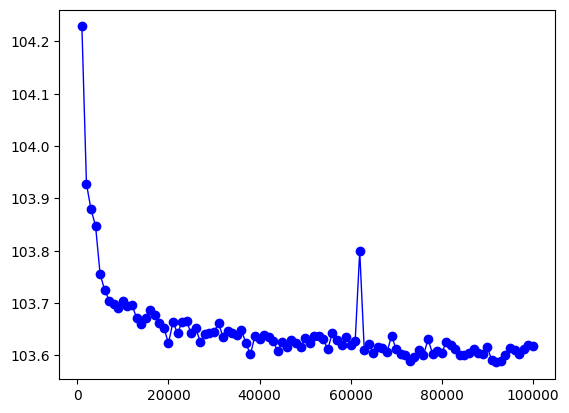

In [14]:
# グラフ表示
import matplotlib.pyplot as plt

axes = plt.subplot()
axes.plot(
    history['loss_epochs'],
    history['loss_values'],
    "-",
    c="Blue",
    linewidth=1,
    marker='o',
    alpha=1
)

plt.show()

torch.Size([16, 6, 128, 128])


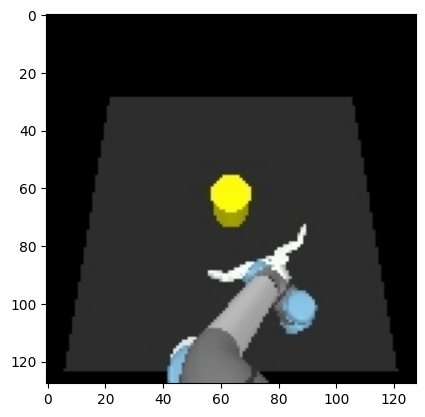

In [17]:
(
        observation,
        observation_pose,
        target_X,
        img_coef,
        pose_coef,
        target_Y,
        target_Y_pose,
        data_id,
        target_time
    )  = next(iter(train_dataloader))

print(target_Y.shape)
plt.imshow(target_Y[0][:3,:,:].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 6, 128, 128])


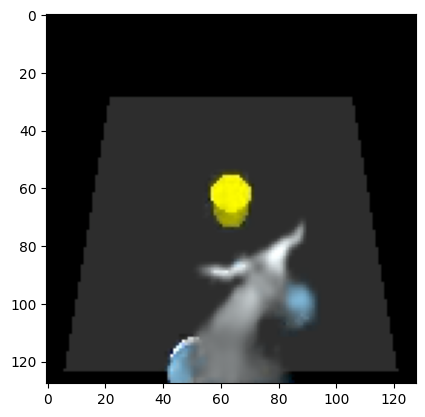

In [18]:
        observation = observation.to(device)
        observation_pose = observation_pose.to(device)
        target_X = target_X.to(device)
        img_coef = img_coef.to(device)
        pose_coef = pose_coef.to(device)
        target_Y = target_Y.to(device)
        target_Y_pose = target_Y_pose.to(device)
        target_time = target_time.to(device)

imputs = [observation, observation_pose]
coefficients = [img_coef, pose_coef]
out = blending_encoder(imputs, coefficients, target_time)

img = decoders[0](out)
pose = decoders[1](out)
print(img.shape)
plt.imshow(img[0][:3,:,:].permute(1, 2, 0).cpu().detach())